In [2]:
from results.result_processing import get_trace_reduction
from results.utils import (
    make_precision_recall_at_k_df,
    get_precision_at_fpr,
    make_precision_recall_at_k_df_single_threshold,
)
from results.final_model_metrics import get_final_model_metrics
from attacks import AttackConfig, LiRAAttack
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt

In [3]:
all_attack_results = {}
all_attacks = {}
all_final_model_metrics = {}

In [ ]:
target_id = "target"
attack = "LiRA"
augment = True
batchsize = 16
num_workers = 8
gpu = ":1"

for dataset in ("CIFAR10", "CIFAR100", "CINIC10"):
    for arch in ("wrn28-2", "wrn40-4", "rn-20"):
        if dataset != "CIFAR10" and arch != "wrn28-2":
            continue

        if dataset == "CIFAR10" and arch == "wrn28-2":
            continue

        exp_id = f"{arch}_{dataset}"
        print(f"Architecture: {arch}, Dataset: {dataset}")
        config = AttackConfig(
            exp_id=exp_id,
            target_id=target_id,
            checkpoint=None,
            arch=arch,
            dataset=dataset,
            attack=attack,
            augment=augment,
            batchsize=batchsize,
            num_workers=num_workers,
            gpu=gpu,
        )
        attack = LiRAAttack(config)
        results = attack.run()

        df_final_model_metrics = get_final_model_metrics(
            model=attack.model, data_loader=attack.attack_loaders[0]
        )
        df_final_model_metrics = pd.merge(df_final_model_metrics, results, left_index=True, right_index=True)

        metrics = make_precision_recall_at_k_df_single_threshold(
            scores_df = df_final_model_metrics,
            ground_truth_df=results,
            fpr_threshold=0.001,
            k_frac=0.01,
        )

        print(metrics)

        trace = get_trace_reduction(exp_id, reduction="iqr")
        trace_df = pd.DataFrame({'trace_value': trace})
        trace_df = pd.merge(trace_df, results, left_index=True, right_index=True)

        metrics = make_precision_recall_at_k_df_single_threshold(
            scores_df = trace_df,
            ground_truth_df=results,
            fpr_threshold=0.001,
            k_frac=0.01,
        )

        print(metrics)

        all_attack_results[(arch, dataset)] = results
        all_attacks[(arch, dataset)] = attack
        all_final_model_metrics[(arch, dataset)] = df_final_model_metrics

        df_final_model_metrics.to_csv(f"data/final_model_metrics_{arch}_{dataset}.csv", index=True)

In [20]:
final_model_metrics = {}
for arch, dataset in list(all_attacks.keys()) + [('wrn28-2', "CIFAR10")]:
    df = pd.read_csv(f"data/final_model_metrics_{arch}_{dataset}.csv", index_col=0)
    final_model_metrics[(arch, dataset)] = df

In [28]:
results = []
for (arch, dataset), df in final_model_metrics.items():
    metrics = make_precision_recall_at_k_df_single_threshold(
        scores_df=df,
        ground_truth_df=df,  # Using same df since it contains ground truth
        fpr_threshold=0.001,
        k_frac=0.01,
    )
    metrics['architecture'] = arch
    metrics['dataset'] = dataset
    results.append(metrics)

results_dfs = [pd.DataFrame([metric]) for metric in results]
combined_metrics = pd.concat(results_dfs, axis=0)
combined_metrics.index = combined_metrics.apply(lambda x: x['architecture'] + "_" + x['dataset'], axis=1)
combined_metrics.T  # Transpose to swap rows and columns

pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
combined_metrics.T # Print transposed metrics with no truncation


,wrn40-4_CIFAR10,rn-20_CIFAR10,wrn28-2_CIFAR100,wrn28-2_CINIC10,wrn28-2_CIFAR10
spearman_loss,0.013881,0.325082,0.262193,0.213315,0.163612
spearman_confidence,0.01874,0.321111,0.247914,0.217877,0.175863
spearman_param_grad_norm,0.079165,0.323321,0.264883,0.246394,0.2095
spearman_param_grad_var,0.079184,0.323317,0.264885,0.246393,0.209502
spearman_input_grad_norm,0.151215,0.323732,0.269151,0.25409,0.229175
spearman_input_grad_var,0.151215,0.323732,0.269151,0.25409,0.229175
spearman_shap_norm,0.163064,0.032545,0.060551,0.182064,0.146975
spearman_shap_var,0.162622,0.032543,0.057786,0.184597,0.148814
spearman_lira_score,1.0,1.0,1.0,1.0,1.0
fpr,0.00104,0.00104,0.00104,0.001022,0.00104


In [31]:
results = []
for (arch, dataset), df in final_model_metrics.items():
    exp_id = f"{arch}_{dataset}"

    trace = get_trace_reduction(exp_id, reduction="iqr")
    trace_df = pd.DataFrame({'trace_value': trace})
    trace_df = pd.merge(trace_df, df, left_index=True, right_index=True)

    metrics = make_precision_recall_at_k_df_single_threshold(
        scores_df = trace_df,
        ground_truth_df=trace_df,
        fpr_threshold=0.001,
        k_frac=0.01,
    )
    
    metrics['architecture'] = arch
    metrics['dataset'] = dataset
    results.append(metrics)

results_dfs = [pd.DataFrame([metric]) for metric in results]
trace_metrics = pd.concat(results_dfs, axis=0)
trace_metrics.index = trace_metrics.apply(lambda x: x['architecture'] + "_" + x['dataset'], axis=1)
trace_metrics.T  # Transpose to swap rows and columns

# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# combined_metrics.T # Print transposed metrics with no truncation


,wrn40-4_CIFAR10,rn-20_CIFAR10,wrn28-2_CIFAR100,wrn28-2_CINIC10,wrn28-2_CIFAR10
spearman_trace_value,0.654473,0.495297,0.747859,0.693568,0.615619
spearman_loss,0.013881,0.325082,0.262193,0.213315,0.163612
spearman_confidence,0.01874,0.321111,0.247914,0.217877,0.175863
spearman_param_grad_norm,0.079165,0.323321,0.264883,0.246394,0.2095
spearman_param_grad_var,0.079184,0.323317,0.264885,0.246393,0.209502
spearman_input_grad_norm,0.151215,0.323732,0.269151,0.25409,0.229175
spearman_input_grad_var,0.151215,0.323732,0.269151,0.25409,0.229175
spearman_shap_norm,0.163064,0.032545,0.060551,0.182064,0.146975
spearman_shap_var,0.162622,0.032543,0.057786,0.184597,0.148814
spearman_lira_score,1.0,1.0,1.0,1.0,1.0


Spearman correlation between trace values and LIRA scores: 0.616


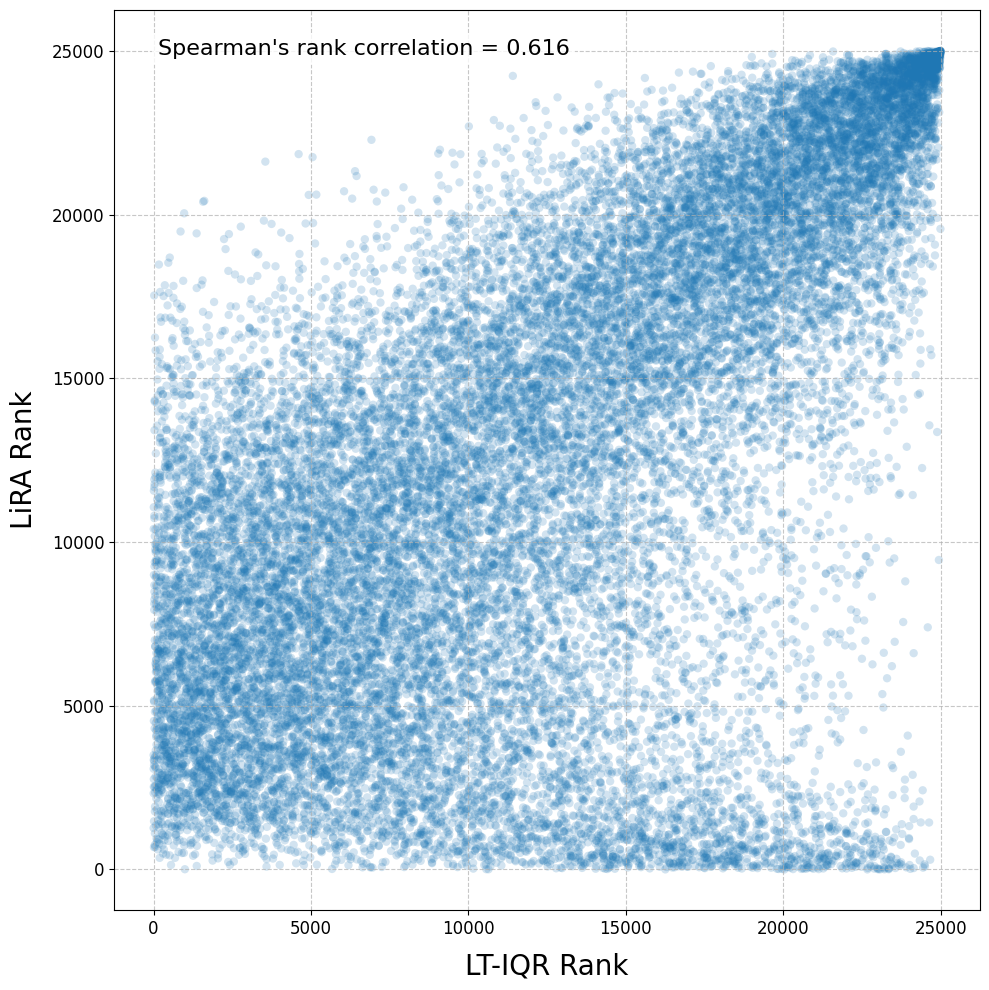

In [56]:
correlation = trace_df[trace_df["target_trained_on"]]["trace_value"].corr(
    trace_df[trace_df["target_trained_on"]]["lira_score"], method="spearman"
)

print(f"Spearman correlation between trace values and LIRA scores: {correlation:.3f}")

plt.figure(figsize=(10, 10))
plt.scatter(
    trace_df[trace_df["target_trained_on"]]["trace_value"]
    .rank()
    .sample(n=25000, random_state=42),
    trace_df[trace_df["target_trained_on"]]["lira_score"]
    .rank()
    .sample(n=25000, random_state=42),
    alpha=0.2,
    color='#1f77b4',
    edgecolor='none'
)

plt.grid(True, linestyle='--', alpha=0.7)
# plt.title('Correlation between LT-IQR and LiRA Rankings', pad=20, fontsize=14)
plt.xlabel("LT-IQR Rank", fontsize=20, labelpad=10)
plt.ylabel("LiRA Rank", fontsize=20, labelpad=10)

# Add correlation text to plot
plt.text(0.05, 0.95, f"Spearman's rank correlation = {correlation:.3f}", 
         transform=plt.gca().transAxes,
         fontsize=16,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
# plt.xlim(0,25000)
# plt.ylim(0,25000)
plt.savefig('figures/spearman.pdf')

# plt.show()
